In [1]:
import os
import time

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torchvision.utils as tvutils
from torchvision.datasets import ImageFolder

import cv2
import PIL
import matplotlib.pyplot as plt

from my_utils import data, models

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

In [2]:
UseGPU = torch.cuda.is_available()
device = torch.device("cuda" if UseGPU else "cpu")
print(f"Using {device} now!")

Using cuda now!


In [3]:
batch_size = 128
fig_resize = 32
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((fig_resize, fig_resize))
])
loader_kwargs = {
    'batch_size': batch_size,   # default:1
    'shuffle': True,            # default:False
    'num_workers': 4,           # default:0
    'pin_memory': False,        # default:False
    'drop_last': True,          # default:False
    'prefetch_factor': 4,       # default:2
    'persistent_workers': False # default:False
}

In [4]:
# 制作二进制数据集
train_data = data.MyDataset('Datasets/polygons_unfilled_32/train', transform=T)
train_loader = DataLoader(train_data, **loader_kwargs)

val_data = data.MyDataset('Datasets/polygons_unfilled_32/val', transform=T)
val_loader = DataLoader(val_data, **loader_kwargs)

test_data = data.MyDataset('Datasets/polygons_unfilled_32/test', transform=T)
test_loader = DataLoader(test_data, **loader_kwargs)

In [5]:
sample_step = 10

small_train_data = Subset(train_data, torch.arange(0, len(train_data) - 1, sample_step))
small_train_loader = DataLoader(small_train_data, **loader_kwargs)

small_val_data = Subset(val_data, torch.arange(0, len(val_data) - 1, sample_step))
small_val_loader = DataLoader(small_val_data, **loader_kwargs)

In [6]:
# check data before training!
img, label = train_data[0]
print(len(train_data), '\t', img.shape)
imgs, labels = next(iter(train_loader))
print(len(train_loader), '\t', imgs.shape)

img, label = val_data[0]
print(len(val_data), '\t', img.shape)
imgs, labels = next(iter(val_loader))
print(len(val_loader), '\t', imgs.shape)

40000 	 torch.Size([1, 32, 32])
312 	 torch.Size([128, 1, 32, 32])
8000 	 torch.Size([1, 32, 32])
62 	 torch.Size([128, 1, 32, 32])


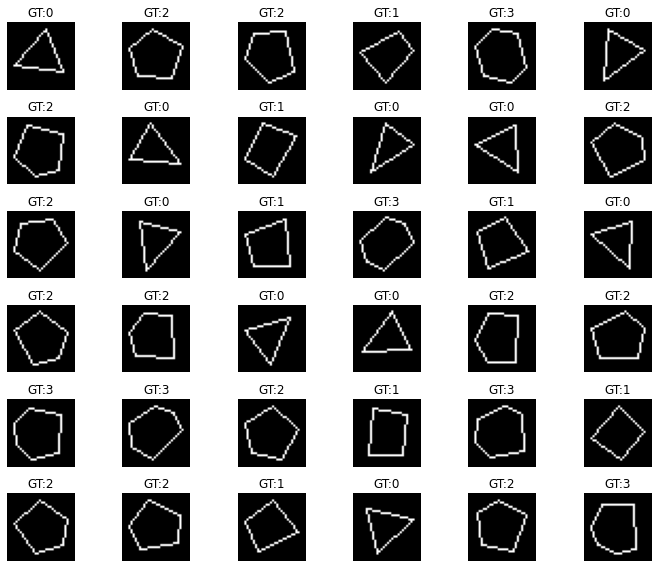

In [7]:
vis = imgs.permute(0, 2, 3, 1)
fig = plt.figure()
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.title(f"GT:{labels[i]}")
    plt.imshow(vis[i], 'gray')
    plt.axis('off')
plt.tight_layout()

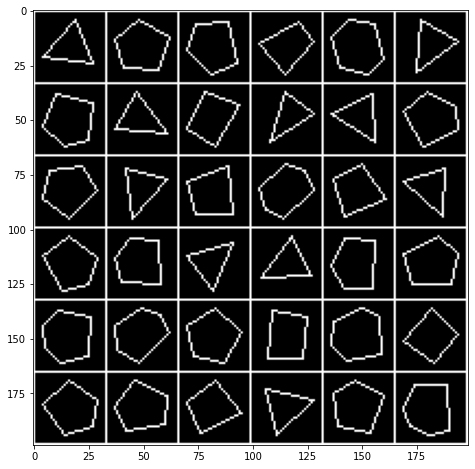

In [8]:
imgs_grid = tvutils.make_grid(imgs[:36], nrow=6, padding=1, pad_value=1)
plt.imshow(imgs_grid.permute(1,2,0))

In [9]:
def check_accuracy(test_model, loader):
    num_correct = 0
    num_samples = 0
    test_model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for batch_idx, (X, Y) in enumerate(loader):
            X = X.to(device, dtype=torch.float32)  # move to device, e.g. GPU
            Y = Y.to(device, dtype=torch.int)
            scores = test_model(X)
            num_correct += (scores.argmax(axis=1) == Y).sum()
            num_samples += len(scores)
        return float(num_correct) / num_samples

def train(model, optimizer, loss_fn, train_loader,
          check_fn, check_loaders, batch_step, epochs=2, log_every=10):
    check_loader_train = check_loaders['train']
    check_loader_val = check_loaders['val']
    iters = len(train_loader)
    for epoch in range(1, epochs + 1):
        tic = time.time()
        for batch_idx, (X, Y) in enumerate(train_loader):
            batch_step += 1
            model.train()
            X = X.to(device, dtype=torch.float32)
            Y = Y.to(device, dtype=torch.int64)
            scores = model(X)
            loss = loss_fn(scores, Y)
            writer.add_scalar('loss', loss.item(), batch_step)
            writer.add_scalar('lr', optimizer.param_groups[0]['lr'], batch_step)

            # back propagate
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step(batch_step / iters)

            # check accuracy
            if batch_idx % log_every == 0:
                model.eval()
                train_acc = check_fn(model, check_loader_train)
                val_acc = check_fn(model, check_loader_val)
                writer.add_scalars('acc', {'train':train_acc, 'val':val_acc}, batch_step)
                print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.5f}\tVal acc: {:.1f}%'.format(
                    epoch, batch_idx * batch_size, len(train_loader.dataset),
                           100. * batch_idx / len(train_loader),
                           loss, 100. * val_acc))

        print('====> Epoch: {}\tTime: {}s'.format(epoch, time.time() - tic))

    return batch_step

In [10]:
model = models.my_ConvNeXt(in_chans=1, num_classes=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.1)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)
loss_func = nn.CrossEntropyLoss()

In [11]:
writer = SummaryWriter()
# writer.add_graph(model, torch.rand([1, 1, 32, 32], device=device))

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [12]:
# reset train history
batch_step = 0

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.1)

In [13]:
# Train and test!

check_loaders = {'train':small_train_loader,
                 'val':small_val_loader}

Epoch: 0 [0/40000 (0%)]	Loss: 1.37046	Val acc: 24.3%
Epoch: 0 [6400/40000 (16%)]	Loss: 1.34420	Val acc: 24.6%
Epoch: 0 [12800/40000 (32%)]	Loss: 1.33070	Val acc: 35.8%
Epoch: 0 [19200/40000 (48%)]	Loss: 1.29414	Val acc: 44.7%
Epoch: 0 [25600/40000 (64%)]	Loss: 1.31376	Val acc: 46.9%
Epoch: 0 [32000/40000 (80%)]	Loss: 1.29949	Val acc: 48.2%
Epoch: 0 [38400/40000 (96%)]	Loss: 1.25780	Val acc: 49.2%
====> Epoch: 0	Time: 79.36443758010864s
Epoch: 1 [0/40000 (0%)]	Loss: 1.27918	Val acc: 49.2%
Epoch: 1 [6400/40000 (16%)]	Loss: 1.26631	Val acc: 49.0%
Epoch: 1 [12800/40000 (32%)]	Loss: 1.22509	Val acc: 50.4%
Epoch: 1 [19200/40000 (48%)]	Loss: 1.21998	Val acc: 48.6%
Epoch: 1 [25600/40000 (64%)]	Loss: 1.16887	Val acc: 50.9%
Epoch: 1 [32000/40000 (80%)]	Loss: 1.17193	Val acc: 53.1%
Epoch: 1 [38400/40000 (96%)]	Loss: 1.12237	Val acc: 53.5%
====> Epoch: 1	Time: 74.36830711364746s
Epoch: 2 [0/40000 (0%)]	Loss: 1.14400	Val acc: 53.3%
Epoch: 2 [6400/40000 (16%)]	Loss: 1.11573	Val acc: 54.2%
Epoch: 2 [

In [15]:
batch_step = train(model, optimizer, loss_func, train_loader,
                   check_fn=check_accuracy,
                   check_loaders=check_loaders,
                   batch_step=batch_step, epochs=4, log_every=50)

Epoch: 0 [0/40000 (0%)]	Loss: 0.95361	Val acc: 59.9%
Epoch: 0 [6400/40000 (16%)]	Loss: 0.78351	Val acc: 53.1%
Epoch: 0 [12800/40000 (32%)]	Loss: 0.88601	Val acc: 61.3%
Epoch: 0 [19200/40000 (48%)]	Loss: 0.90887	Val acc: 62.0%
Epoch: 0 [25600/40000 (64%)]	Loss: 0.88474	Val acc: 59.6%
Epoch: 0 [32000/40000 (80%)]	Loss: 0.84434	Val acc: 59.4%
Epoch: 0 [38400/40000 (96%)]	Loss: 0.85527	Val acc: 60.4%
====> Epoch: 0	Time: 73.42689847946167s
Epoch: 1 [0/40000 (0%)]	Loss: 0.79356	Val acc: 61.3%
Epoch: 1 [6400/40000 (16%)]	Loss: 0.85666	Val acc: 58.2%
Epoch: 1 [12800/40000 (32%)]	Loss: 0.81307	Val acc: 62.2%
Epoch: 1 [19200/40000 (48%)]	Loss: 0.80681	Val acc: 61.6%
Epoch: 1 [25600/40000 (64%)]	Loss: 0.83262	Val acc: 60.4%
Epoch: 1 [32000/40000 (80%)]	Loss: 0.80751	Val acc: 63.0%
Epoch: 1 [38400/40000 (96%)]	Loss: 0.88369	Val acc: 59.8%
====> Epoch: 1	Time: 72.70960688591003s
Epoch: 2 [0/40000 (0%)]	Loss: 0.80009	Val acc: 61.5%
Epoch: 2 [6400/40000 (16%)]	Loss: 0.79304	Val acc: 63.0%
Epoch: 2 [

In [16]:
writer.close()

In [18]:
model.eval()
test_acc = check_accuracy(model, test_loader)
print('Test accuracy is : %.2f%%' % (100. * test_acc))

Test accuracy is : 61.71%


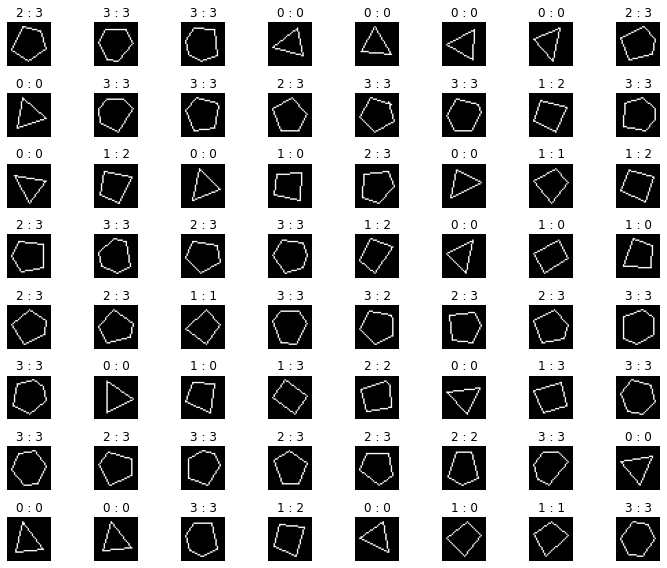

In [19]:
imgs, labels = next(iter(test_loader))
scores = model(imgs.to(device))
preds = scores.argmax(axis=1)

vis = imgs.permute(0, 2, 3, 1)
fig = plt.figure()
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.title(f"{labels[i]} : {preds[i]}")
    plt.imshow(vis[i], 'gray')
    plt.axis('off')
plt.tight_layout()

In [20]:
# Save weights of the model above
model_paras = model.state_dict()
print("Model parameters:")
for k, v in model_paras.items():
    print(f"{k}:\t {v.size()}")

optim_paras = optimizer.state_dict()
print("\nOptimizer parameters:")
for k, v in optim_paras.items():
    print(f"{k}")

save_time = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
save_path = "saved_models/polygen_myconvnext_" + save_time + ".pt"
torch.save({
    "model_paras": model_paras,
    "optim_paras": optim_paras
}, save_path)
print(f"\nSuccessfully saved to {save_path}")

Model parameters:
connection_layers.0.weight:	 torch.Size([8, 1])
connection_layers.0.bias:	 torch.Size([8])
connection_layers.1.weight:	 torch.Size([16, 8])
connection_layers.1.bias:	 torch.Size([16])
connection_layers.2.weight:	 torch.Size([32, 16])
connection_layers.2.bias:	 torch.Size([32])
norm_layers.0.weight:	 torch.Size([8])
norm_layers.0.bias:	 torch.Size([8])
norm_layers.0.running_mean:	 torch.Size([8])
norm_layers.0.running_var:	 torch.Size([8])
norm_layers.0.num_batches_tracked:	 torch.Size([])
norm_layers.1.weight:	 torch.Size([8])
norm_layers.1.bias:	 torch.Size([8])
norm_layers.1.running_mean:	 torch.Size([8])
norm_layers.1.running_var:	 torch.Size([8])
norm_layers.1.num_batches_tracked:	 torch.Size([])
norm_layers.2.weight:	 torch.Size([16])
norm_layers.2.bias:	 torch.Size([16])
norm_layers.2.running_mean:	 torch.Size([16])
norm_layers.2.running_var:	 torch.Size([16])
norm_layers.2.num_batches_tracked:	 torch.Size([])
stages.0.0.gamma:	 torch.Size([8])
stages.0.0.dwconv

In [18]:
# reload modal paras from saved .pt file
new_model = models.my_ConvNeXt()

new_model.to(device)
new_optimizer = torch.optim.Adam(new_model.parameters())

save_path = 'saved_models/polygen_myconvnext_2022_01_17_21_50_07.pt'
checkpoint = torch.load(save_path)
new_model.load_state_dict(checkpoint["model_paras"])
new_optimizer.load_state_dict(checkpoint["optim_paras"])

In [19]:
new_model.eval()
test_acc = check_accuracy(test_loader, new_model)
print('Test accuracy is : %.2f%%' % (100. * test_acc))

Test accuracy is : 41.60%


In [24]:
imgs, labels = next(iter(test_loader))
scores = new_model(imgs.to(device))
preds = scores.argmax(axis=1)

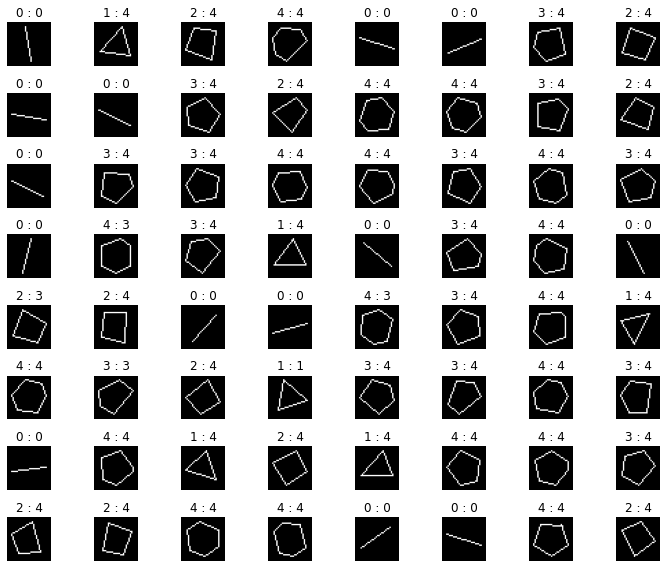

In [26]:
vis = imgs.permute(0, 2, 3, 1)
fig = plt.figure()
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.title(f"{labels[i]} : {preds[i]}")
    plt.imshow(vis[i], 'gray')
    plt.axis('off')
plt.tight_layout()